# Sea Ice Concentration

From the NSIDC Sea Ice Monthly historical - calculate climatogy and averages for sea ice conc and extent

In [1]:
#directory paths
_work_dir='/g/data/jk72/as2285/miz/'
_data_dir='/g/data/jk72/MIZ/'

In [2]:
#some constants
CLIMAT_DATES=[1981,2010]
EAST_ANT_LONS=[71,160] #longitudes for east Antartica (easterly)
YEAR=2022
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


In [3]:
#useful py libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker

In [4]:
# import local functions
import sys
sys.path.append(_work_dir)
from utils.sea_ice_conc import sea_ice_conc

%run {_work_dir}utils/plot_tools.ipynb

# Open the dataset

Using the NSIDC Sea Ice Concentration gridded data set, historical monthly averages of sea ice concentration

In [6]:
hist_cdr_xr = xr.open_dataset(
    f'{_data_dir}/NSIDC/G02202_V4/seaice_conc_monthly_sh_197811_202112_v04r00.nc',
    #chunks='auto'
).swap_dims(
    {'tdim':'time', 'x':'xgrid','y':'ygrid'}
).rename(
    {'cdr_seaice_conc_monthly':'cdr_seaice_conc','xgrid':'x','ygrid':'y'}
)

We are going to compare this to the current (2022) conditions:

In [7]:
daily_files = ! ls -d {_data_dir}/NSIDC/G10016_V2/daily/*.nc

In [8]:
daily_da=xr.concat(
    [
        xr.open_dataset(
            iFile,
        ).swap_dims(
            {'tdim':'time', 'x':'xgrid','y':'ygrid'}
        ).rename(
            {'xgrid':'x','ygrid':'y'}
        ) for iFile in daily_files
    ], 
    'time'
)

#we could resample to monlthy, but daily data actually works fine
current_cdr_xr=daily_da#.resample(time='M',label='left', loffset='1D').mean('time')

Put the historical monthly data, and the near real time data in one array:

In [9]:
# If the two datasets have gone out of sync, raise an error.
# This would be amiguous, the historical (released data) and the current (near-real time data) 
# are covering the same times and we don't know which one to use.
if hist_cdr_xr.time_coverage_end>current_cdr_xr.time_coverage_start:
    raise RuntimeError("Times in historical data overlap with near-real time data")

cdr_ds=xr.concat(
    [hist_cdr_xr.cdr_seaice_conc, current_cdr_xr.cdr_seaice_conc], #this is the only data field we use
    'time'
)

#merge the long and lat back in for convenience
cdr_xr=xr.merge(
    [
        cdr_ds,
        hist_cdr_xr.longitude,
        hist_cdr_xr.latitude]
)

cdr_xr

<xarray.Dataset>
Dimensions:          (time: 767, x: 316, y: 332)
Coordinates:
  * time             (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2022-09-06
  * x                (x) float32 -3.938e+06 -3.912e+06 ... 3.912e+06 3.938e+06
  * y                (y) float32 4.338e+06 4.312e+06 ... -3.912e+06 -3.938e+06
Data variables:
    cdr_seaice_conc  (time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude        (y, x) float32 ...
    latitude         (y, x) float32 ...
Attributes:
    long_name:            NOAA/NSIDC Climate Data Record of Passive Microwave...
    standard_name:        sea_ice_area_fraction
    units:                1
    flag_values:          [251 252 253 254 255]
    flag_meanings:        pole_hole lakes coastal land_mask missing_data
    datum:                +ellps=urn:ogc:def:crs:EPSG::4326
    grid_mapping:         projection
    reference:            https://nsidc.org/data/g02202/versions/4/
    ancillary_variables:  stdev_of_cdr_seaice_conc_monthly qa_of_cdr_seaice_c...
    valid_range:          [  0 100]
    cell_methods:         tdim: mean

Annoyingly, the area of each grid cell is provided seperately:

In [10]:
datFile=open('/g/data/jk72/MIZ/NSIDC/pss25area_v3.dat', 'rb')
#pss25area_v3.dat: 316 columns x 332 rows
areasDmNd=np.fromfile(datFile, dtype=np.int32).reshape([332,316])

#Divide by 1000 to get km2
areasKmNd=areasDmNd/1000

# Climatologies for sea ice extent and area

Climatologies for extent and area of sea ice. 

Extent is the total area of the ocean where the concetration of sea ice is estimated to be greater than 15%

Area is the area of the sea ice only (smaller than extent). Concentrations less than 15% were discarded prior to calculating this area

In [11]:
ant_conc=sea_ice_conc(cdr_xr.cdr_seaice_conc, areasKmNd ) #local class

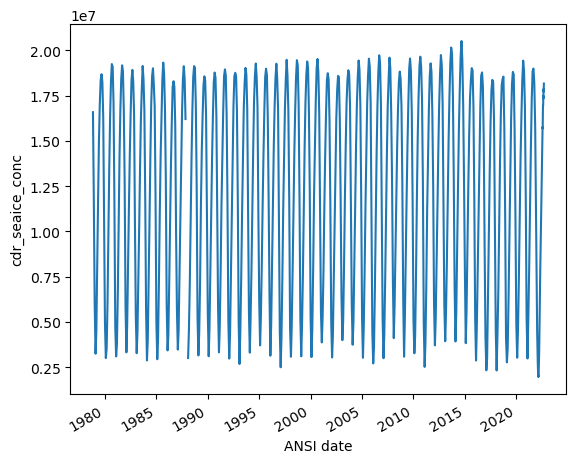

In [12]:
ant_conc.calc_extent()
ant_conc.extent_da.plot(); #plot for sanity showing gap in data
#CDR has a gap in the data from 03 December 1987 through 12 January 1988 (ref: https://nsidc.org/data/g02202)

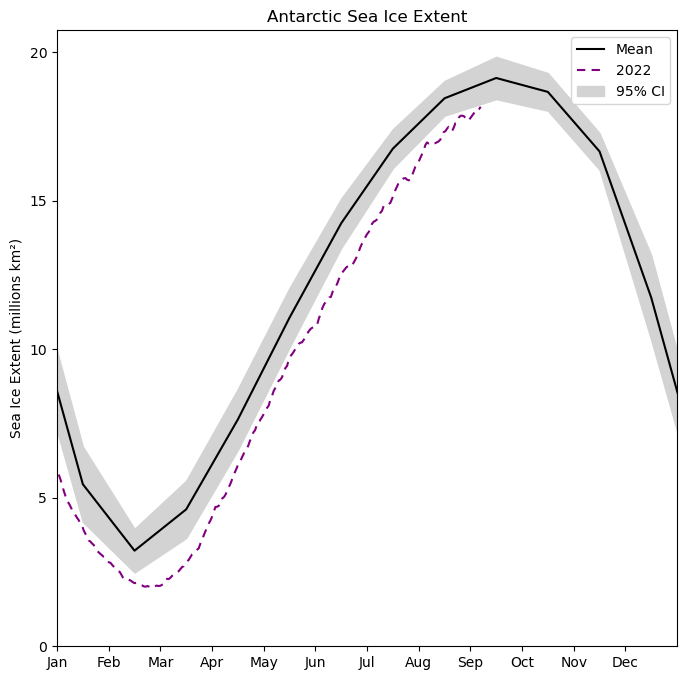

In [14]:
plt.figure(figsize=[8,8])
plt.subplot()

plot_climat_monthly(ant_conc.extent_climat_ds)

plot_year(ant_conc.extent_da, YEAR)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.title('Antarctic Sea Ice Extent')
plt.legend()
# plt.savefig(f'{_work_dir}figures/nsidc_sea_ice_extent_2022.svg')

In [15]:
ant_conc.calc_area()

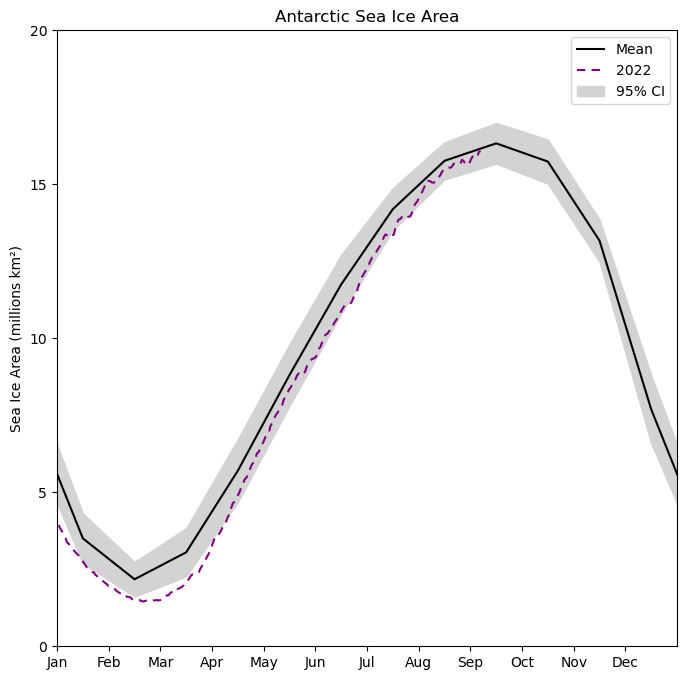

In [17]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat_monthly(ant_conc.area_climat_ds)

plot_year(ant_conc.area_da, YEAR)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.title('Antarctic Sea Ice Area')
plt.show()

# Climatologies for east Antarctic only

In [18]:
EAST_ANT_LONS

[71, 160]

In [19]:
e_ant_conc=sea_ice_conc(
    cdr_xr.where(
        (cdr_xr.longitude>EAST_ANT_LONS[0])
        *(cdr_xr.longitude<EAST_ANT_LONS[1])
    ).cdr_seaice_conc, 
    areasKmNd
)

e_ant_conc.calc_extent()

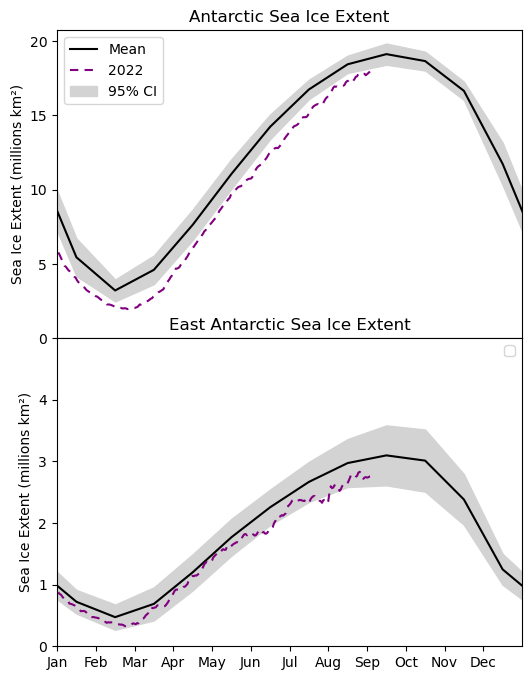

In [21]:
plt.figure(figsize=[6,8])
plt.subplot(2,1,1)

plot_climat_monthly(ant_conc.extent_climat_ds)

plot_year(ant_conc.extent_da, YEAR)

plt.yticks(
    ticks=[0, 5e6, 10e6, 15e6, 20e6],
    labels=['0','5','10','15','20']
)
plt.xticks(ticks=[5], labels=['_'])
plt.ylabel('Sea Ice Extent (millions km\u00b2)')

plt.title('Antarctic Sea Ice Extent')

plt.subplot(2,1,2)

plot_climat_monthly(e_ant_conc.extent_climat_ds)

plot_year(e_ant_conc.extent_da, YEAR)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)
plt.ylim([0,5e6])

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent (millions km\u00b2)')
plt.legend([])

plt.subplots_adjust(hspace=.0)

# plt.savefig(f'{_work_dir}figures/nsidc_sea_ice_extent_2022_ea.svg', bbox_inches='tight')

In [22]:
e_ant_conc.calc_area()

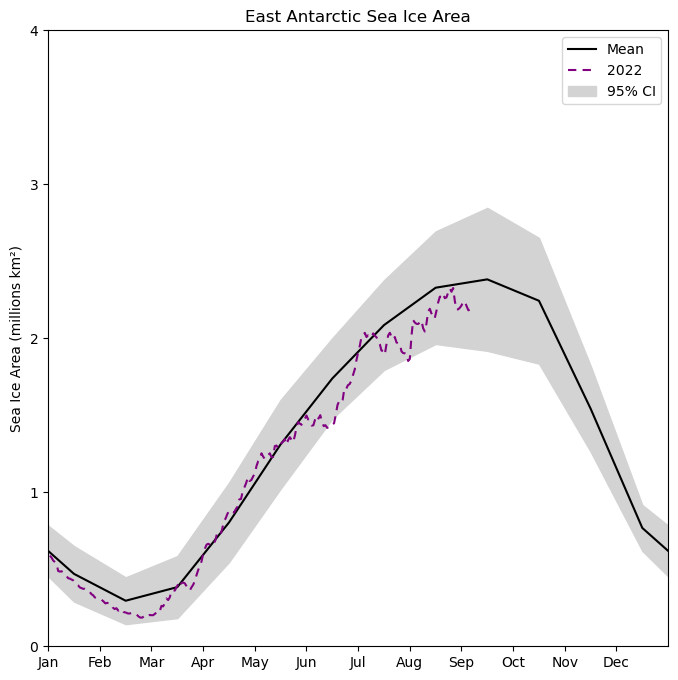

In [23]:
plt.figure(figsize=[8,8])

plt.subplot()

plot_climat_monthly(e_ant_conc.area_climat_ds)

plot_year(e_ant_conc.area_da, YEAR)

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Area')
plt.ylabel('Sea Ice Area (millions km\u00b2)')

plt.show()

# Distribution of sea ice

Monthly mean concentrations (1981-2010)

In [20]:
ant_conc.calc_gridded_anoms()

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfu

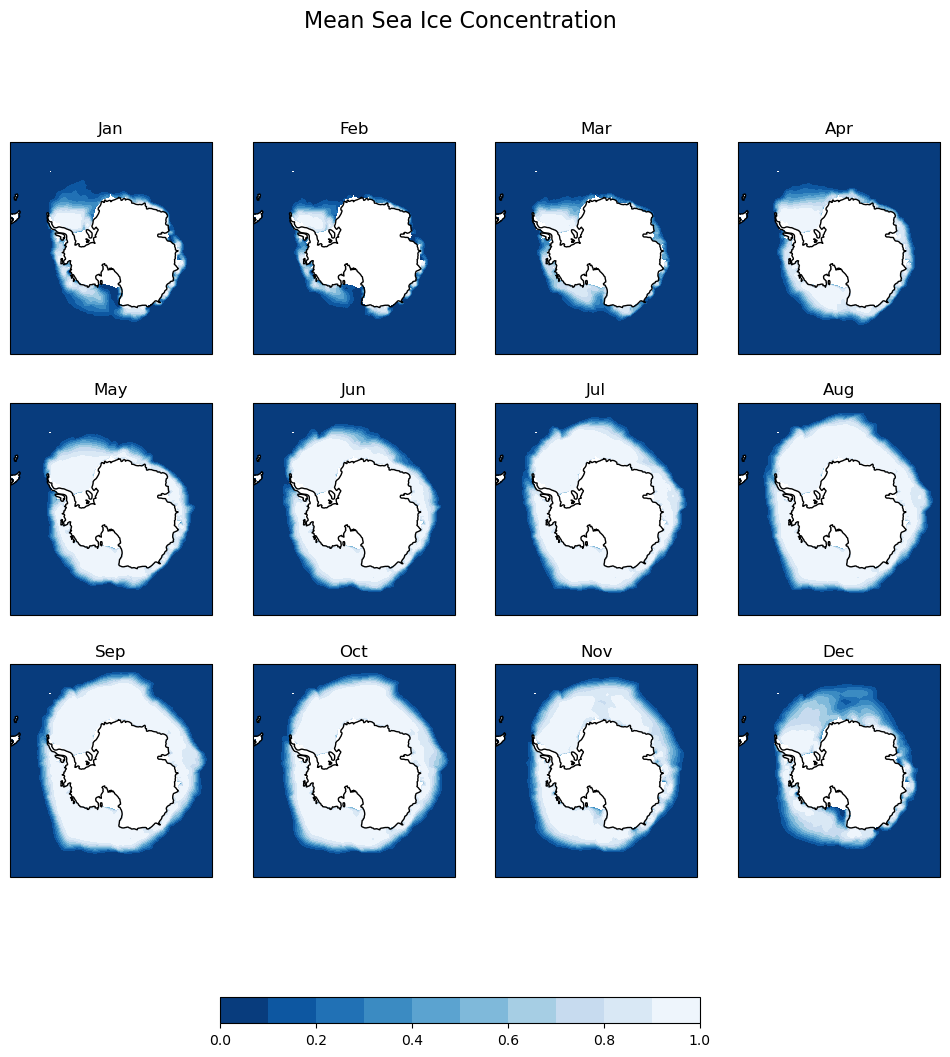

In [21]:
plt.figure(figsize=(12,13))
plt.suptitle('Mean Sea Ice Concentration', fontsize=16)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=iMonth)
    
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title(months[iMonth-1])
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

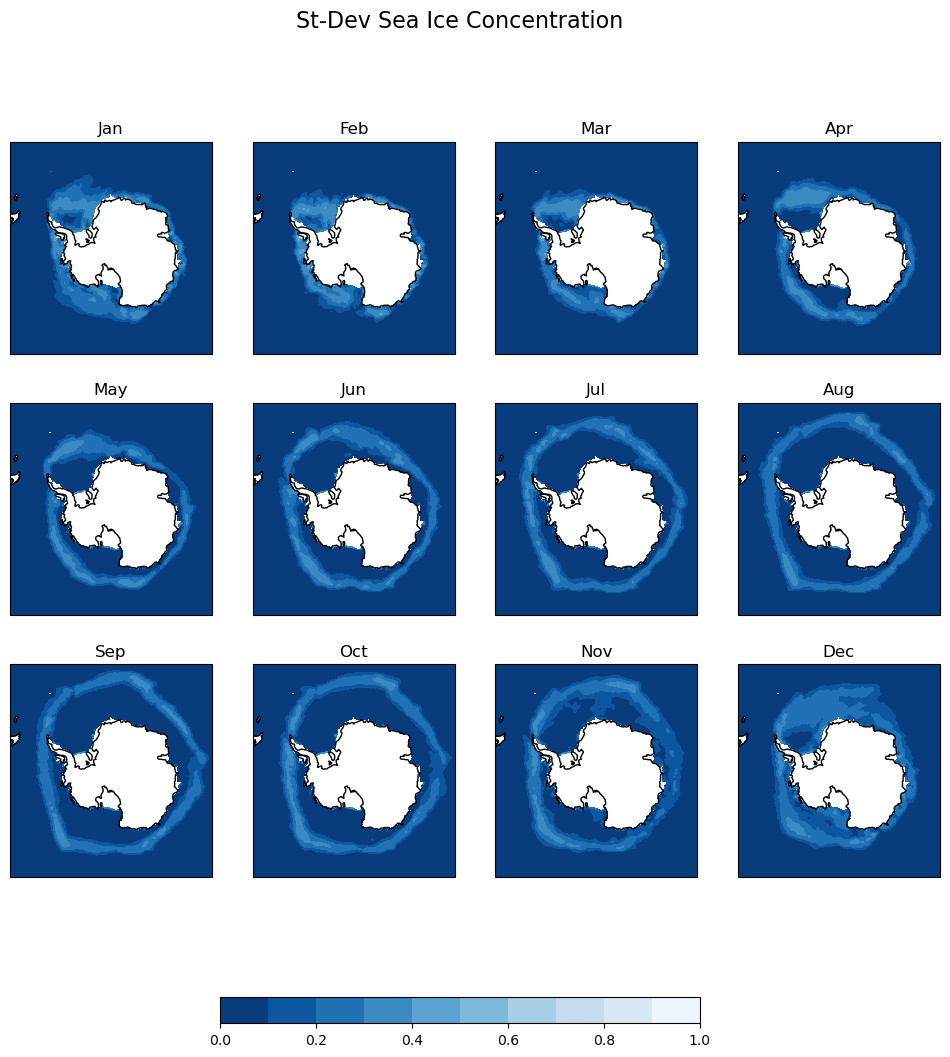

In [22]:
plt.figure(figsize=(12,13))
plt.suptitle('St-Dev Sea Ice Concentration', fontsize=16)

for iMonth in ant_conc.conc_climat_ds.month.values:
    
    ax = plt.subplot(4,4,iMonth,projection=ccrs.SouthPolarStereo())
    
    toPlot=ant_conc.conc_climat_ds.st_dev.sel(month=iMonth)
    
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=np.arange(0,1.04,.1),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )

    #gl = ax.gridlines(
    #    draw_labels=False, linewidth=2, color='gray', alpha=0.5, linestyle='--'
    #)

    ax.coastlines()
    plt.title(months[iMonth-1])
    
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.3,0.2,0.4,0.02]))
plt.show()

# anomalies in distribution of sea ice

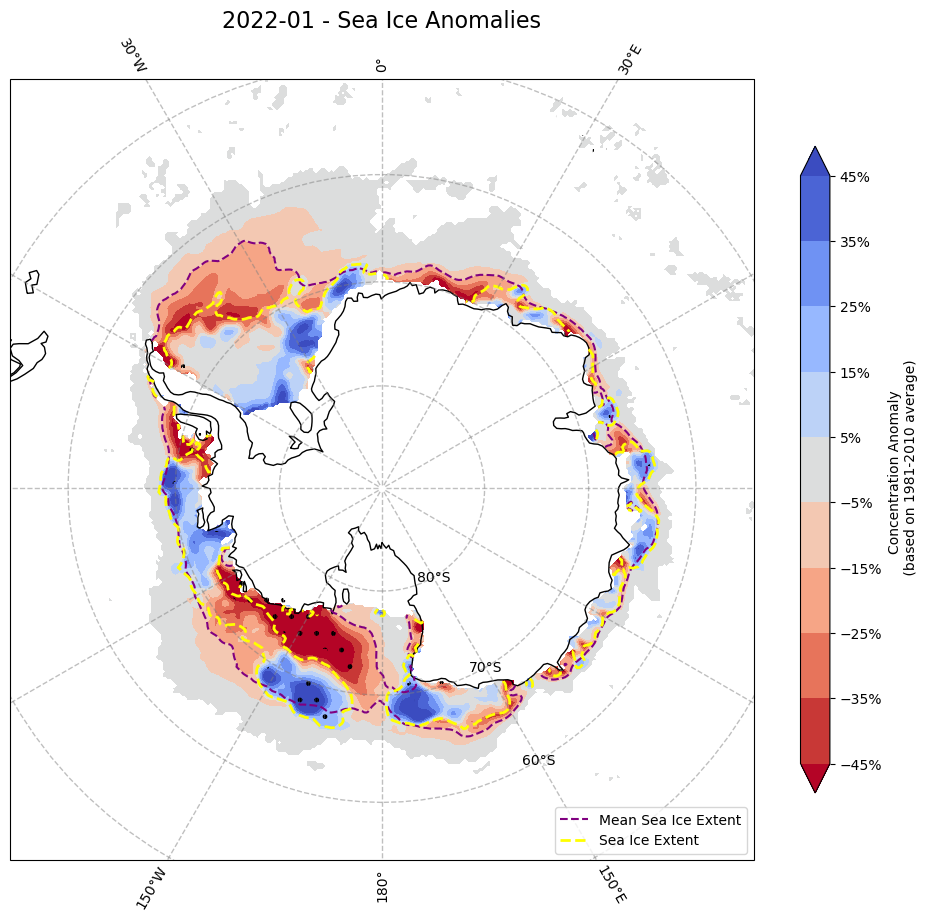

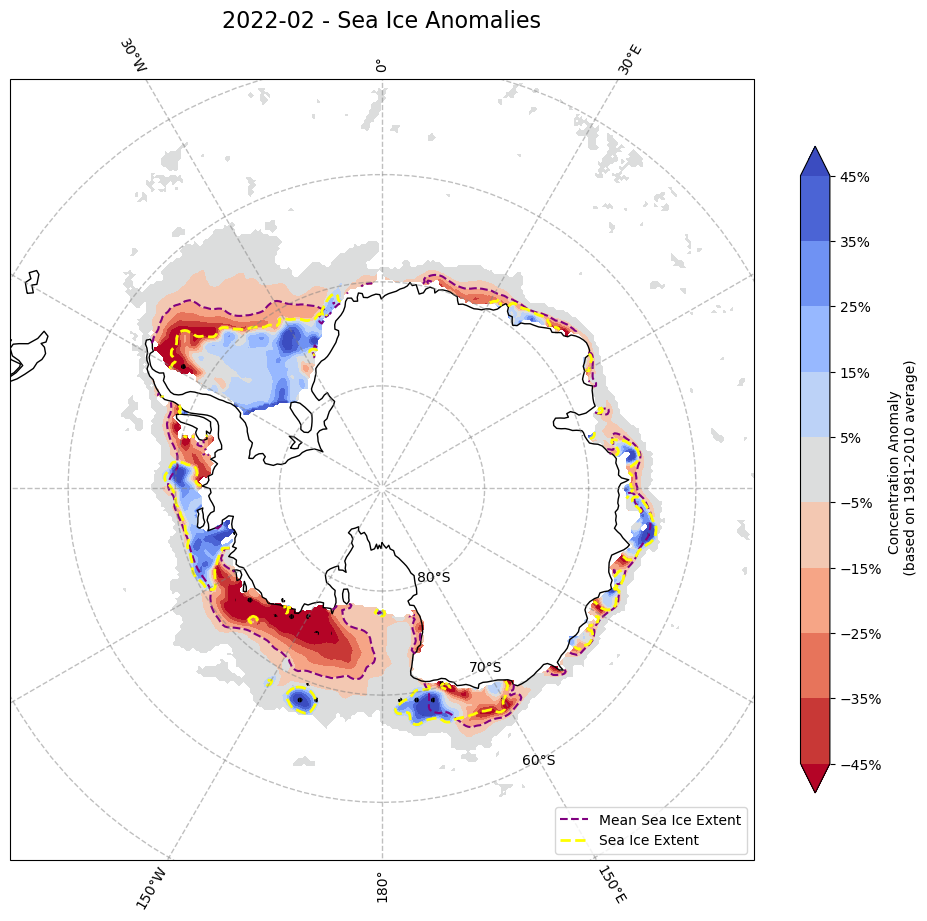

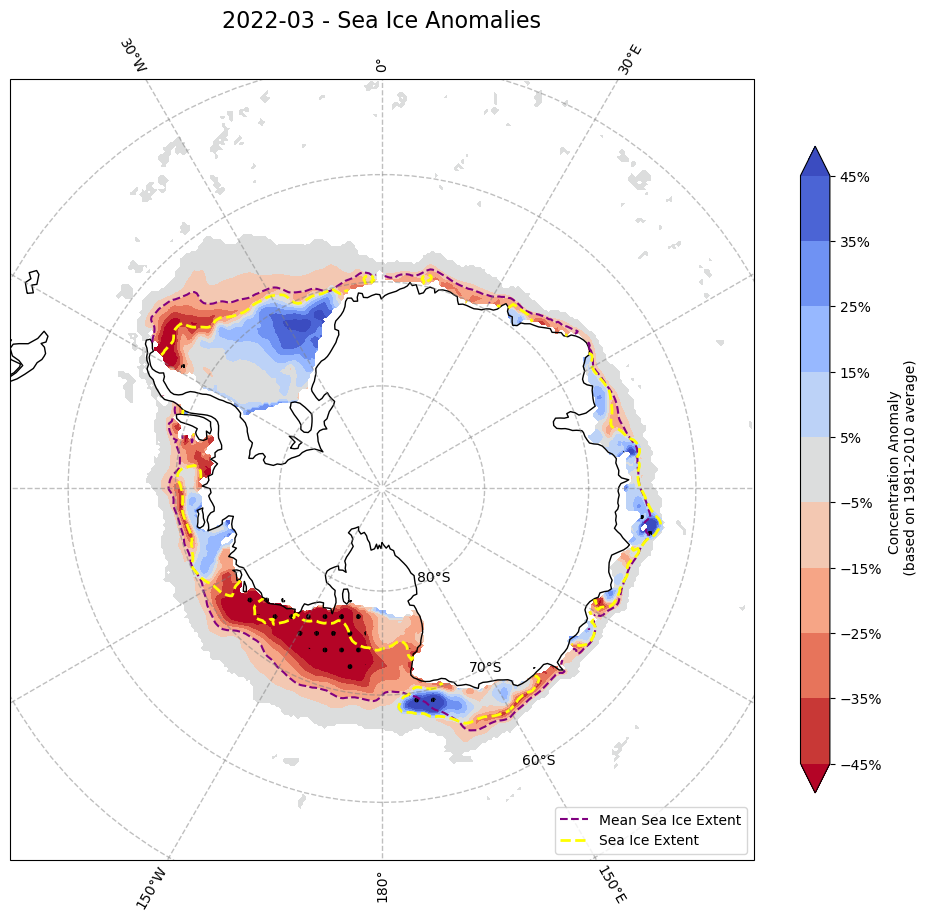

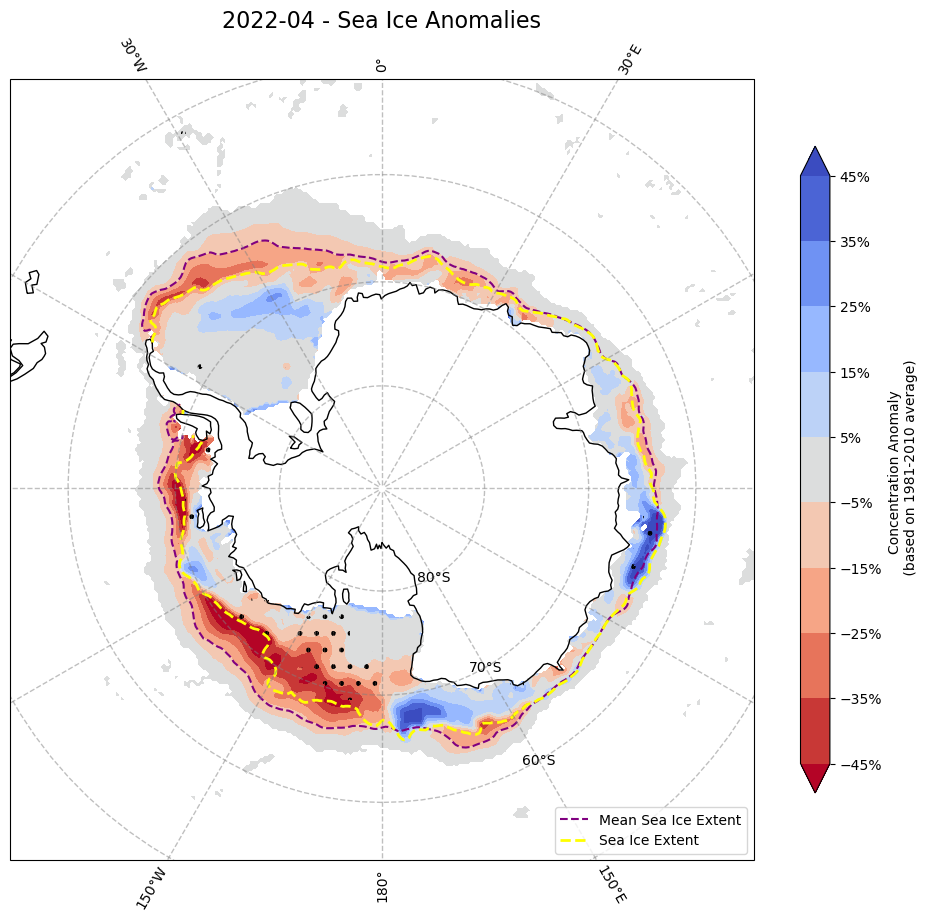

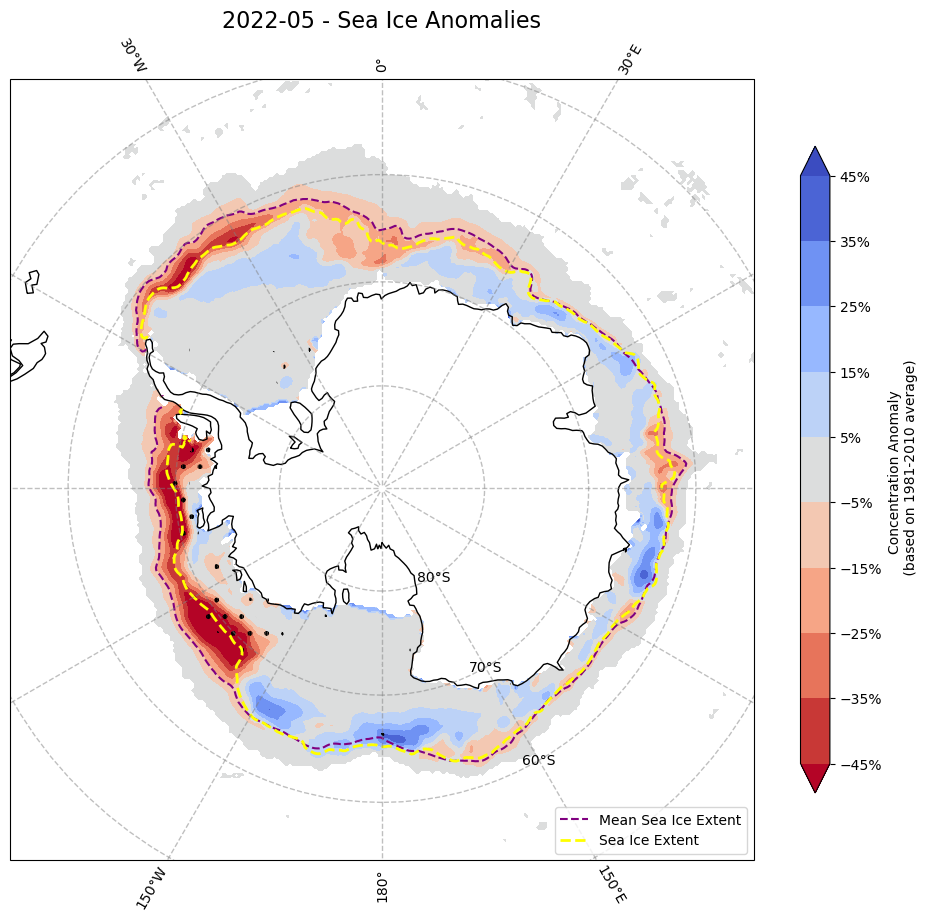

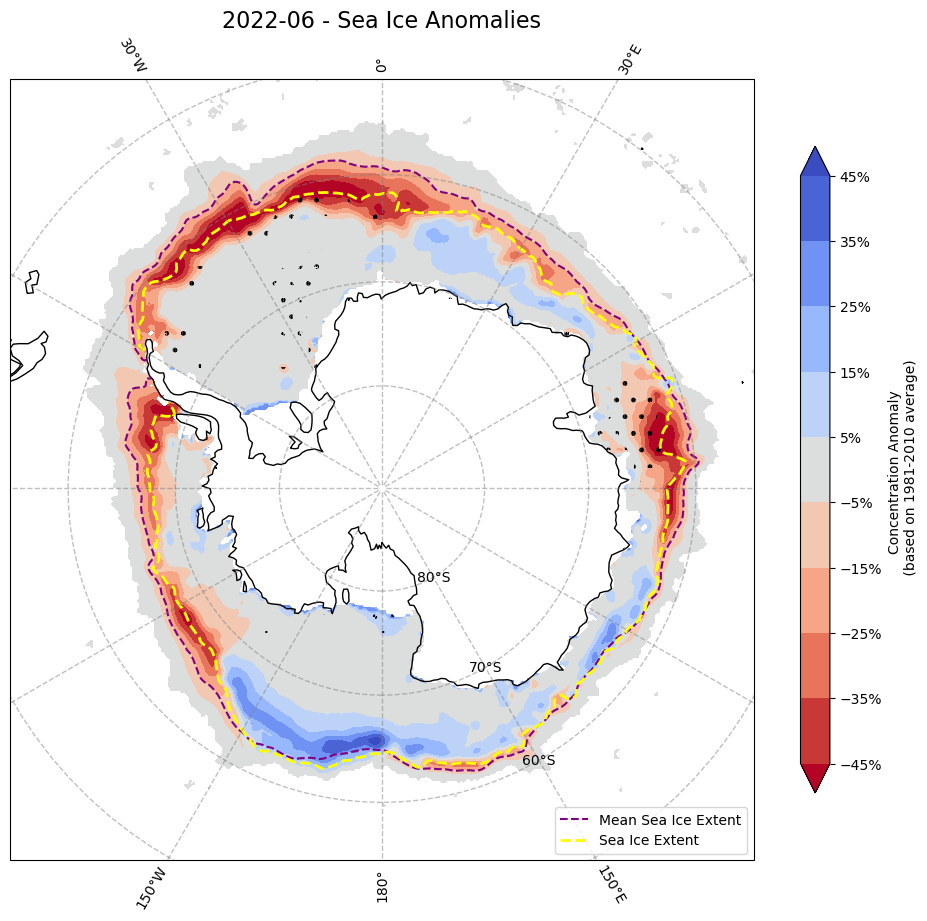

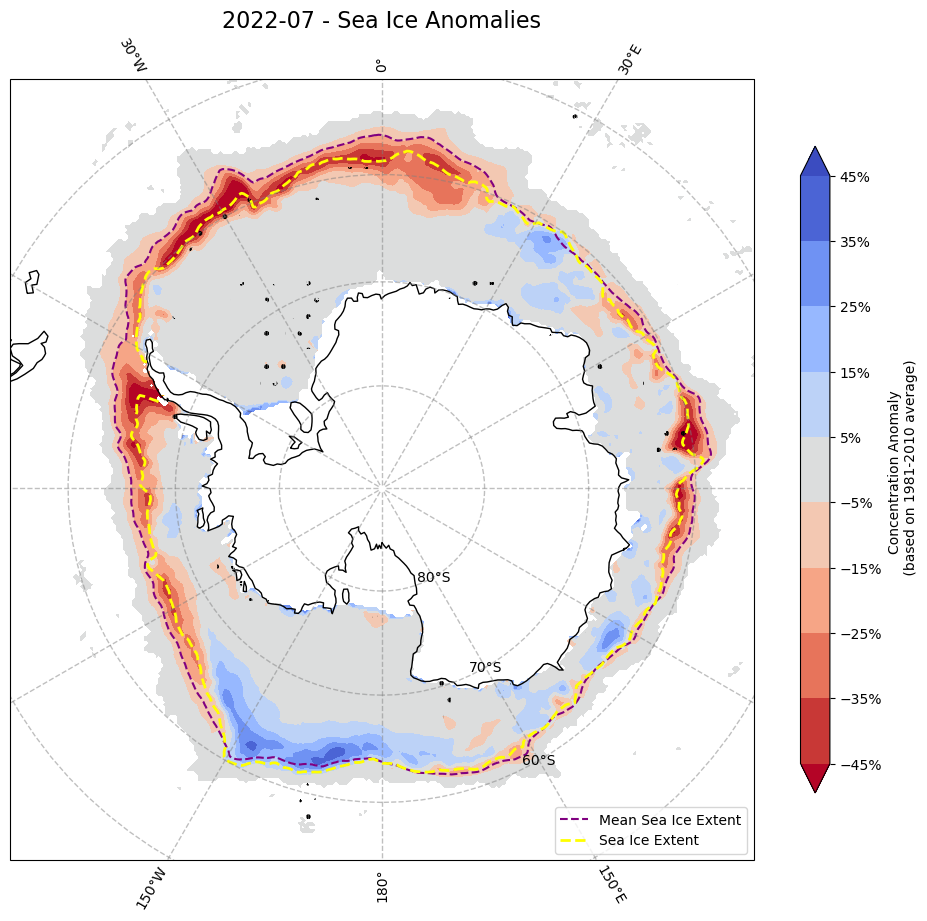

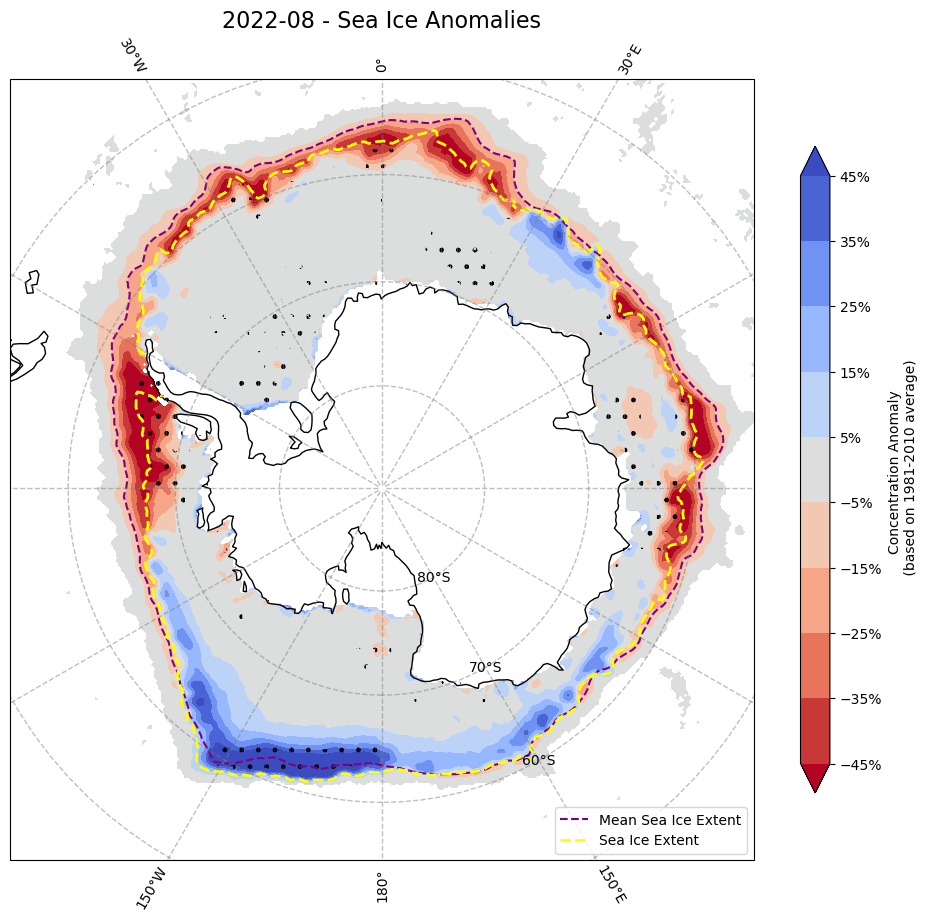

In [23]:
months_in_YEAR = np.unique(ant_conc.da.sel(time=slice(str(YEAR),str(YEAR))).time.dt.month)

for MONTH in months_in_YEAR:

    plt.figure(figsize=(12,12))
    ax=plt.subplot(projection=ccrs.SouthPolarStereo())


    #sea ice extent climatology for month
    toPlot=ant_conc.conc_climat_ds.ave.sel(month=MONTH)
    cs1=plt.contour(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=1.5,
        linestyles='dashed',
    )

    #sea ice extent for YEAR + month
    toPlot=ant_conc.monthly_da.sel(time=f'{YEAR:04.0f}-{MONTH:02.0f}').isel(time=0)
    cs2=plt.contour(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=[.15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='yellow',
        linewidths=2,
        linestyles='dashed'
    )

    #sea ice conc anoms
    toPlot_anoms=ant_conc.anoms_da.sel(time=f'{YEAR:04.0f}-{MONTH:02.0f}').isel(time=0)
    plt.contourf(
        toPlot_anoms.x, 
        toPlot_anoms.y, 
        toPlot_anoms,
        levels=np.arange(-0.45,0.46,.1),
        extend='both',
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='coolwarm_r',
    )

    plt.colorbar(
        shrink=0.7, 
        format=ticker.PercentFormatter(xmax=1),
        label='Concentration Anomaly \n (based on 1981-2010 average)'
    )

    plot_stipling(
        toPlot_anoms,
        2*ant_conc.conc_climat_ds.st_dev.sel(month=MONTH),
        ax
    )

    gl = ax.gridlines(
        draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
        xlocs=[-150,-120,-90,-60,-30,0,30,60,90,120,150,180], ylocs=[-50,-60,-70,-80]
    )

    ax.coastlines()

    plt.title((f'{YEAR:04.0f}-{MONTH:02.0f} - Sea Ice Anomalies'), fontsize=16)
    #ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())
    
    cs1.collections[0].set_label(s='Mean Sea Ice Extent') 
    cs2.collections[0].set_label(s='Sea Ice Extent') 

    plt.legend(loc='lower right')

    #plt.savefig(f'{_work_dir}figures/nsidc_sea_ice_conc_anoms_{YEAR}_{MONTH}_ea.svg',bbox_inches='tight')
    plt.show()

# Trends in Min / max extent in East Antarctica

In [24]:
min_extents=e_ant_conc.extent_da.groupby('time.year').min()
max_extents=e_ant_conc.extent_da.groupby('time.year').max()

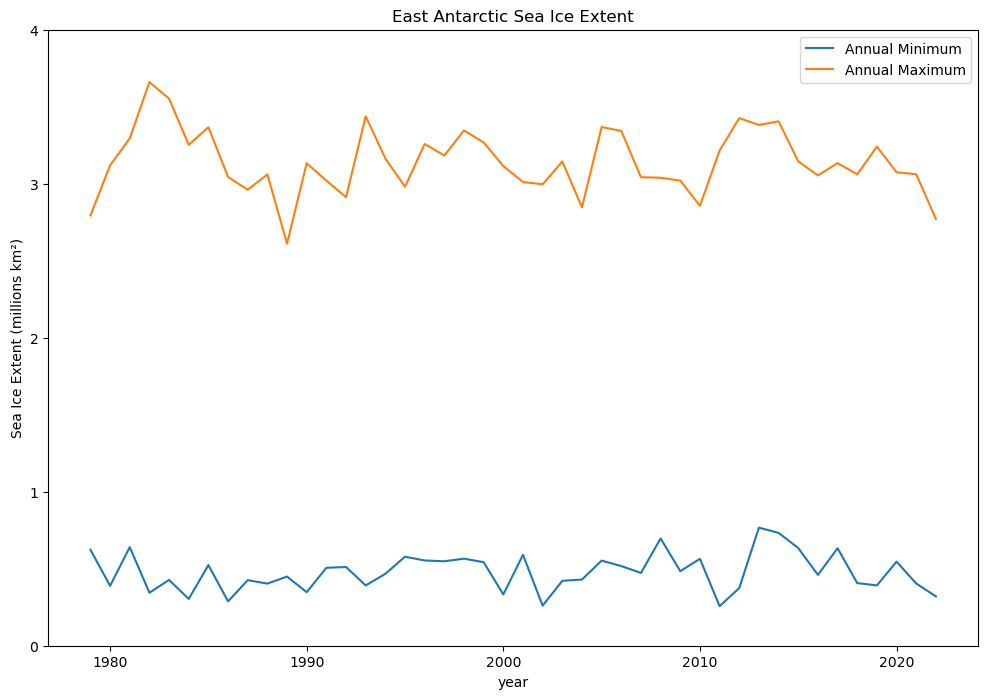

In [25]:
plt.figure(figsize=(12,8))

min_extents[1:].plot(label='Annual Minimum') #don't plot the first year (partial)
max_extents[1:].plot(label='Annual Maximum') 

plt.yticks(
    ticks=[0, 1e6, 2e6, 3e6, 4e6],
    labels=['0','1','2','3','4']
)

plt.title('East Antarctic Sea Ice Extent')
plt.ylabel('Sea Ice Extent (millions km\u00b2)')
plt.legend()

plt.show()

This figure is probably not interesting. There is no trend (well established elsewhere) and variability capture in climatology by month.

# East Antartic High Res Sea Ice Concentration

Monthly Conc using bremen artist - this dataset only starts in 2012, so we are probably mostly interested in current conditions

In [26]:
artist_monthly_xr=xr.open_dataset(f'{_data_dir}/processed/asi2_monthly.nc') # This file is the output from running processing.artist_aggregator

In [27]:
artist_areas_xr=xr.open_dataarray(f'{_data_dir}/Bremen/PolStereo_GridCellArea_s6.25km_Antarctic.nc')

In [28]:
artist_monthly_xr

<xarray.Dataset>
Dimensions:  (x: 1264, y: 1328, time: 122)
Coordinates:
  * x        (x) float64 -3.947e+06 -3.941e+06 ... 3.941e+06 3.947e+06
  * y        (y) float64 -3.947e+06 -3.941e+06 ... 4.341e+06 4.347e+06
  * time     (time) datetime64[ns] 2012-07-31 2012-08-31 ... 2022-08-31
Data variables:
    conc     (time, y, x) float32 ...
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  5.2.1 (r15220) [64-bit] [MP]
    history:      Mon Jan 21 19:51:26 2019: GDAL CreateCopy( /ssmi/www/htdocs...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 2.1.3, released 2017/20/01

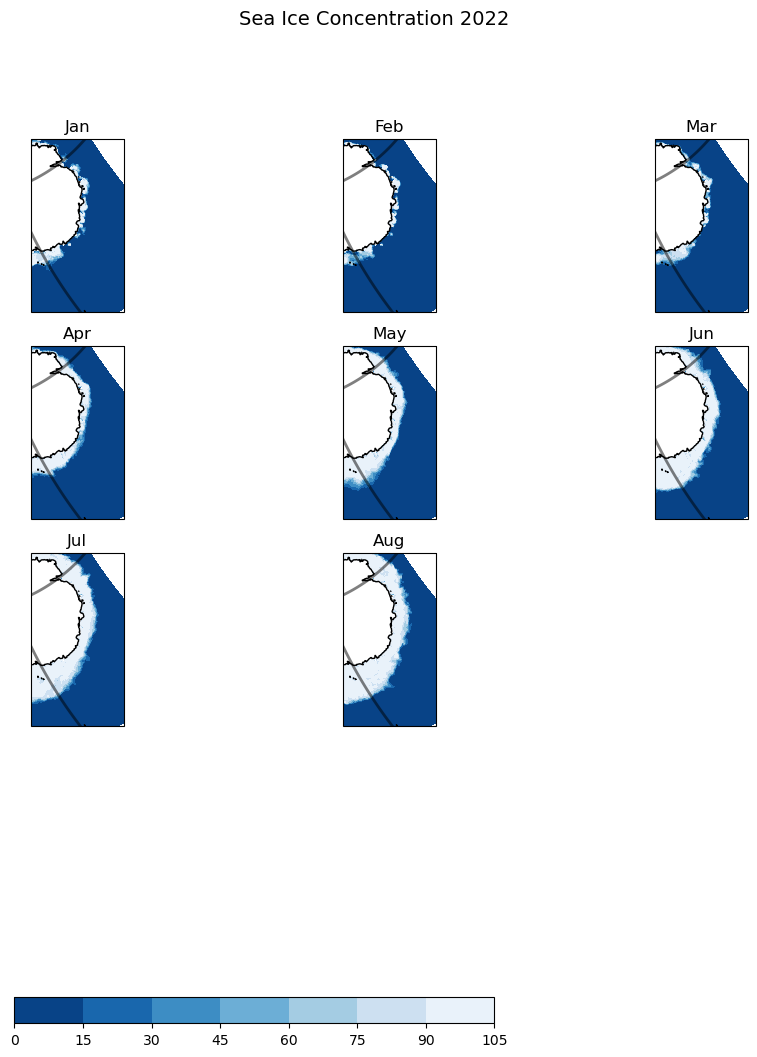

In [29]:
months_in_current_year=artist_monthly_xr.time.sel(time=slice(str(YEAR),str(YEAR)))

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration ' + str(YEAR), fontsize = 14)

i=0

for iMonth in months_in_current_year:
    i+=1
    ax = plt.subplot(5,3,i,
        projection=ccrs.Stereographic()#central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2)
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    toPlot=artist_monthly_xr.sel(time=iMonth).conc
    
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        #levels=[0.2,0.4,0.6,0.8,0.9,1.00],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='Blues_r',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[i-1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

In [30]:
artist_ant_conc=sea_ice_conc(
    artist_monthly_xr.conc, 
    artist_areas_xr, 
    climat_dates=[2012,2020],
    conc_range=[15,100]
)

artist_ant_conc.calc_gridded_anoms()

YEAR=2022

/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/jk72/as2285/miniconda3/envs/sea-ice-tracker/lib/python3.10/site-packages/numpy/lib/nanfu

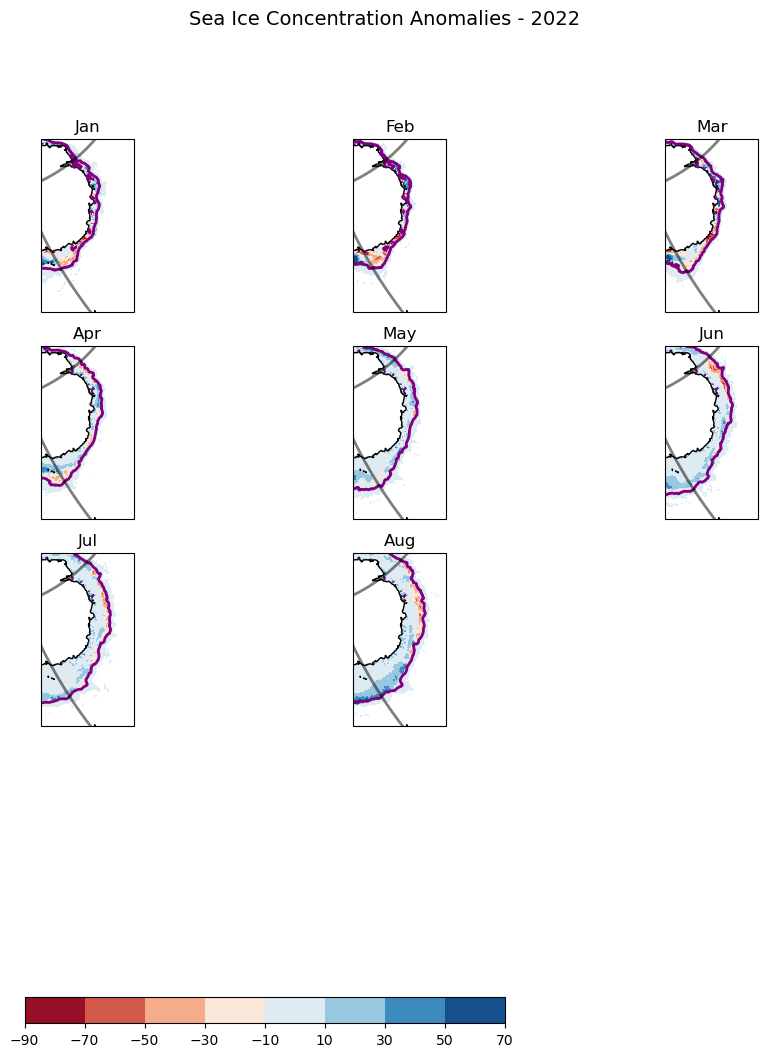

In [31]:
months_in_current_year=artist_monthly_xr.time.sel(time=slice(str(YEAR),str(YEAR))) #datetime obj for each month in the year we are plotting

plt.figure(figsize=(12,13))
plt.suptitle('Sea Ice Concentration Anomalies - ' + str(YEAR), fontsize = 14)

i=0 # a count of which month we are in
for iMonth in months_in_current_year:
    i+=1 
    ax = plt.subplot(
        5,3,i,
        projection=ccrs.Stereographic(
            #central_longitude=(EAST_ANT_LONS[0]+EAST_ANT_LONS[1])/2
            )
        )
    
    ax.set_extent([EAST_ANT_LONS[0], EAST_ANT_LONS[1], -75, -55], crs=ccrs.PlateCarree())

    #include a line for the sea ice extent
    toPlot=artist_ant_conc.conc_climat_ds.ave.sel(month=iMonth.dt.month.values)
    plt.contour(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=[15],
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        colors='purple',
        linewidths=2
    )

    
    toPlot=artist_ant_conc.anoms_da.sel(time=iMonth)
    plt.contourf(
        toPlot.x, 
        toPlot.y, 
        toPlot,
        levels=np.arange(-90,90,20),
        transform=ccrs.SouthPolarStereo(true_scale_latitude=-70),
        cmap='RdBu',
        )
    
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), xlocs=[EAST_ANT_LONS[0], EAST_ANT_LONS[1]], ylocs=[],
        draw_labels=False, linewidth=2, color='black', alpha=0.5, #linestyle='--'
    )

    ax.coastlines()
    plt.title(months[i-1])

plt.subplots_adjust(hspace=0.2,wspace=0.02)
plt.axes
plt.colorbar(orientation='horizontal', cax = plt.axes([0.2,0.2,0.4,0.02]))
plt.show()

# Tracker Files - Monthly PNG - Archive for Reference

Anoms

In [ ]:
for iTime in datetimes_xr:

    plt.figure(figsize=(79,83), dpi=4, frameon=False, facecolor=None, tight_layout={'pad':0})
    ax=plt.subplot()

    #sea ice conc anoms
    toPlot_anoms=ant_conc.anoms_da.sel(time=iTime)
    cs = plt.contourf(
        toPlot_anoms.x, 
        toPlot_anoms.y, 
        toPlot_anoms.values,
        levels=np.arange(-0.45,0.46,.1),
        extend='both',
        cmap='coolwarm_r'
    )
    
    #Area to add stipling 
    criteria = 2*ant_conc.conc_climat_ds.st_dev.sel(month=iTime.dt.month)
    stipling_area=((toPlot_anoms<-criteria)|(toPlot_anoms>criteria))

    c=plt.pcolor(
        stipling_area.x,
        stipling_area.y,
        np.ma.masked_equal(stipling_area,0),
        hatch='.',
        alpha=0,
        shading='auto',
    )
    
    ax.axis('off')
    
    plt.savefig(
        f'{_data_dir}/tracker_data/sea_ice_conc_anoms/nsidc_sea_ice_conc_anoms_{iTime.dt.year.values}_{iTime.dt.month.values}.svg',
        transparent='True',
    )

    plt.close()

In [ ]:
fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
plt.colorbar(
    mappable=cs,
    cax=ax,
    format=ticker.PercentFormatter(xmax=1),
    label='Concentration Anomaly \n (based on 1981-2010 average)',
    #ticks=[-.45,-.25,-.05,.05,.25,.45]
)

plt.savefig(f'{_data_dir}/tracker_files/sea_ice_conc_anoms_legend.png',
               bbox_inches='tight', transparent="True")

Conc 

In [ ]:
for iTime in datetimes_xr:

    plt.figure(figsize=(316,332), dpi=4, frameon=False, facecolor=None, tight_layout={'pad':0})
    ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=ant_conc.monthly_da.sel(time=iTime)
    to_plot=to_plot.where((to_plot>0.15)*(to_plot<=1))
    
    plt.imshow(
        to_plot.values,
        vmin=0.15,
        vmax=1,
        cmap='Blues_r',
        interpolation='none',
    )

    ax.axis('off')
    
    plt.savefig(
        f'{_data_dir}/tracker_data/sea_ice_conc/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.png',
        transparent="True",
    )

    plt.close()

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cm

In [ ]:
norm=colors.Normalize(vmin=15,vmax=100)
fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
cb=fig.colorbar(
    cm.ScalarMappable(norm=norm, cmap='Blues_r'),
    label='Sea Ice Concentration (%)',
    cax=ax,
    #aspect=2.5
)
cb.set_ticks([15,30,45,60,75,90,100])


plt.savefig(f'{_data_dir}/tracker_files/sea_ice_conc_legend.png',
               bbox_inches='tight', transparent="True")

# Tracker files - Bremen Daily

In [6]:
import os
import pandas as pd
from PIL import Image


In [7]:
bremen_files= ! ls -d {_data_dir}/Bremen/netcdf/*.nc

blues_cm=plt.get_cmap("Blues_r",10)

for iFile in bremen_files[-1:]:

    datetime=pd.to_datetime(
        os.path.basename(iFile)[slice(16,24)],
        format='%Y%m%d'
    )
    
    # plt.figure(figsize=(1327,1264), dpi=1, frameon=False, facecolor=None, tight_layout={'pad':0}) #size and dpi set to be equal to the number of pixels
    # ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=xr.open_dataset(iFile)
    to_plot=to_plot.z 
    to_plot=to_plot[-1:0:-1,:].where((to_plot>15)*(to_plot<=100)) 
    
    to_plot=to_plot.odc.assign_crs("epsg:3031")

    write_cog(to_plot, f'{_data_dir}/bremen_cog/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.tif')

    # png_image.quantize().save(
    #     f'{_data_dir}/tracker_files/hr_sea_ice_conc_test/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.png'
    # )

blues_cm=plt.get_cmap("Blues_r",1024)

for iFile in bremen_files[-60:-59]:

    datetime=pd.to_datetime(
        os.path.basename(iFile)[slice(16,24)],
        format='%Y%m%d'
    )
    
    # plt.figure(figsize=(1327,1264), dpi=1, frameon=False, facecolor=None, tight_layout={'pad':0}) #size and dpi set to be equal to the number of pixels
    # ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=xr.open_dataset(iFile)
    to_plot=to_plot.z 
    to_plot=to_plot[-1:0:-1,:].where((to_plot>15)*(to_plot<=100)) 

    colored_xr=to_plot.odc.colorize(cmap=blues_cm, 
                                    vmin=15, vmax=100)

    png_image=Image.fromarray(colored_xr.values,mode="RGBA").quantize()

    png_image.save(
        f'{_data_dir}/tracker_files/hr_sea_ice_conc/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.png'
    )

import matplotlib.colors as colors
import matplotlib.cm as cm

fig=plt.figure(figsize=(1,5))
ax=plt.subplot()
cb=fig.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0,vmax=100),cmap=blues_cm),
    label='Sea Ice Concentration (%)',
    cax=ax,
    #aspect=2.5
)
cb.set_ticks([15,30,45,60,75,90,100])


plt.savefig(f'{_data_dir}/tracker_files/hr_sea_ice_conc_legend.png', bbox_inches='tight', transparent="True")

for iFile in bremen_files[-1:]:

    datetime=pd.to_datetime(
        os.path.basename(iFile)[slice(16,24)],
        format='%Y%m%d'
    )
    
    plt.figure(figsize=(1327,1264), dpi=1, frameon=False, facecolor=None, tight_layout={'pad':0}) #size and dpi set to be equal to the number of pixels
    ax=plt.subplot() 

    #sea ice conc anoms
    to_plot=xr.open_dataset(iFile)
    to_plot=to_plot.z 
    to_plot=to_plot.where((to_plot>15)*(to_plot<=100)) 
    
    plt.imshow(
        to_plot[-1:0:-1,:],
        vmin=15,
        vmax=100,
        cmap='Blues_r',
        interpolation='none'
    )

    ax.axis('off')
    
    # plt.savefig(
    #     f'{_data_dir}/tracker_files/hr_sea_ice_conc/bremen_sea_ice_conc_{datetime.year}_{datetime.month}_{datetime.day}.png',
    # )
    
    # plt.close()

Confirm the extent is the same as nsidc cdr data

In [ ]:
to_plot.odc.assign_crs('epsg:3412').odc.geobox.extent.exterior.to_crs("epsg:4326").points[:3]

# A python only map

In [ ]:
from ipyleaflet import basemaps,projections, WMSLayer
from ipywidgets import Layout
from sidecar import Sidecar
import leafmap


In [ ]:
POLAR3031 = dict(
    name='EPSG:3031',
    custom=True,
    proj4def="""+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1
        +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs""",
    bounds =[[-2822131.5,-3057369.25],[3744213.75,3822194.25]]
)

In [ ]:
f'{_data_dir}/tracker_files/sea_ice_conc/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.png'

In [ ]:
conc_dict_dict={}
anoms_dict={}
for iTime in datetimes_xr[:-3]:
    conc_dict[f'{iTime.dt.year.values}-{iTime.dt.month.values}']=leafmap.ImageOverlay(
        url=f'{_data_dir}/tracker_files/sea_ice_conc/nsidc_sea_ice_conc_{iTime.dt.year.values}_{iTime.dt.month.values}.png', 
        bounds=bounds, 
        opacity=1,
        name='Sea Ice Concentration'
    )
    """anoms_dict[f'{iTime.dt.year.values}-{iTime.dt.month.values}']=leafmap.ImageOverlay(
        url=f'{_data_dir}/tracker_files/sea_ice_conc_anoms/nsidc_sea_ice_conc_anoms_{iTime.dt.year.values}_{iTime.dt.month.values}.svg', 
        bounds=bounds, 
        opacity=1,
        name='Concentration Anomaly'
    )"""

In [ ]:
spsLayout=Layout(width='800px', height='1200px')

In [ ]:
m = leafmap.Map(center=(-70, 135),
        zoom=1,
        layout=spsLayout,
        basemap=basemaps.NASAGIBS.BlueMarble3031,
        crs=projections.EPSG3031)

m.add_wms_layer(url='http://geos.polarview.aq/geoserver/wms', layers='polarview:coastS10', format='image/png',  transparent=True, attribution='Polarview', crs=POLAR3031, name='Coastline')

m.add_time_slider(
    conc_dict
)
"""m.add_time_slider(
    anoms_dict,
)"""

m.add_wms_layer(url='http://geos.polarview.aq/geoserver/wms', layers='polarview:graticuleS', format='image/png',  transparent=True, attribution='Polarview', crs=POLAR3031, name='Graticule')


display(m)

#sc = Sidecar(title="name")
#with sc:
#display(m)